In [1]:
import sys
import pickle
path: str = '/Users/juanbeta/My Drive/Research/Energy/E-CVRP-TW/Code/'
#path: str = 'C:/Users/jm.betancourt/Documents/Research/Energy//E-CVRP-TW/Code/'

from E_CVRP_TW import  E_CVRP_TW

path += 'Experimentation/'
sys.path.insert(0,path)
import plot_performance as plot

# Define instance to evaluate

In [17]:
env = E_CVRP_TW()
instance = 'c103C15.txt'

# Constructive performance

Display of the performance of the constructive heruristic on the
different instances. The heuristic can be either deterministic or stochastic
on placing stations on the route. 

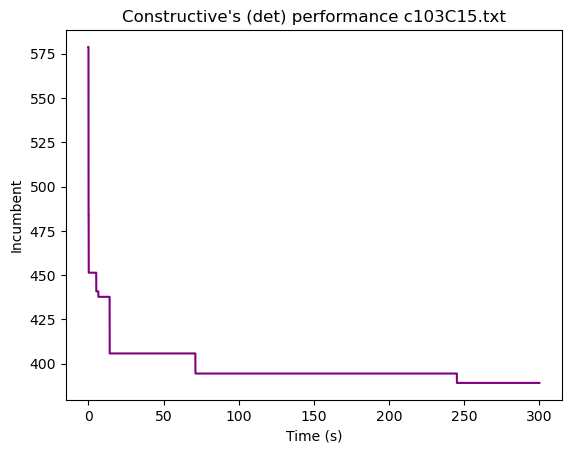

In [18]:
station_placement = 'det' # 'stoch'

plot.plot_const_performance(instance, path, station_placement)

In [3]:
path += 'Constructive/Deterministic RCL Heu/'

file = open(path + f'results_{instance}', 'rb')
data = pickle.load(file)
file.close()

In [4]:
data['best individual']

[['D', 'C85', 'D'],
 ['D', 'C12', 'S5', 'C100', 'D'],
 ['D', 'C30', 'D'],
 ['D', 'C64', 'D']]

In [5]:
data['best distance']

250.03796759039258

In [6]:
data['total time']

2568.967190380583

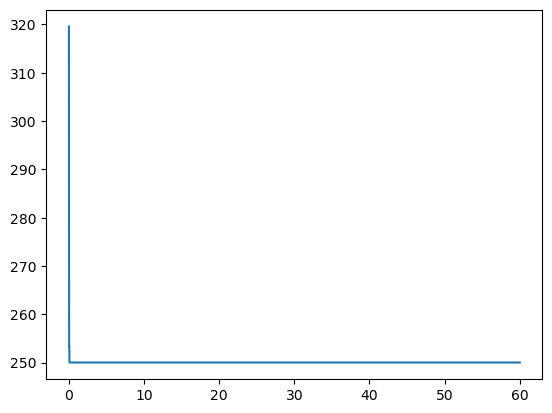

In [7]:
import matplotlib.pyplot as plt
plt.plot(data['inc times'], data['incumbents'])

In [23]:
data['inc times'][-100:]

[299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.97393703460693,
 299.9900224208832,
 299.9900224208832,
 299.9900224208832,
 299.9900224208832,
 299.9900224208832,
 299.9900224208832,
 299.9900224208832,

In [9]:
data['incumbents']

[319.58655817165254,
 301.96047182039405,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 283.36603475558474,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 262.56504061320965,
 253.30183461202233,
 253.30183461202233,
 253.30183461202233,
 253.30183461